# Introducing BESS

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [140]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

In [141]:
os.chdir('/home/MA')

In [142]:
power_balance = pd.read_pickle('Calculations/CH/power_balance_CH_no_AC.pkl')

Define battery size

In [143]:
battery_size = 72

In [144]:
max_c_charge = 0.25
max_c_discharge = 0.5

Roundtrip efficiency solar battery: 85% (check alternative sources) https://www.homerenergy.com/products/pro/docs/latest/battery_roundtrip_efficiency.html#:~:text=The%20battery%20round%2Dtrip%20efficiency,Typically%20it%20is%20about%2080%25.
Assumption: Losses occur during discharging only (Charging efficiency is 99% https://www.powertechsystems.eu/home/tech-corner/lithium-ion-battery-advantages/)

In [145]:
eta_discharge = 0.85

Define function for battery dispatch

In [146]:
from Battery_dispatch_function import BatteryDispatch

In [147]:
power_balance = BatteryDispatch(power_balance, battery_size, eta_discharge, max_c_charge, max_c_discharge)

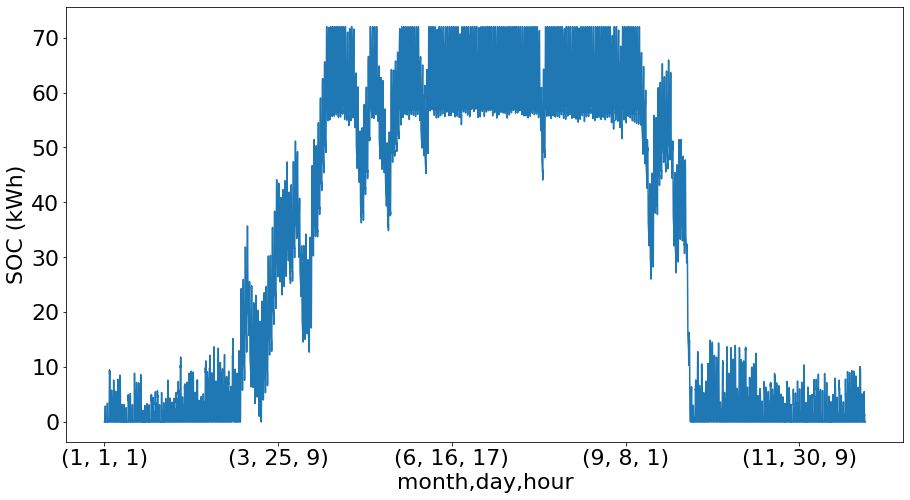

In [148]:
power_balance['SoC'].plot(ylabel = 'SOC (kWh)'); 

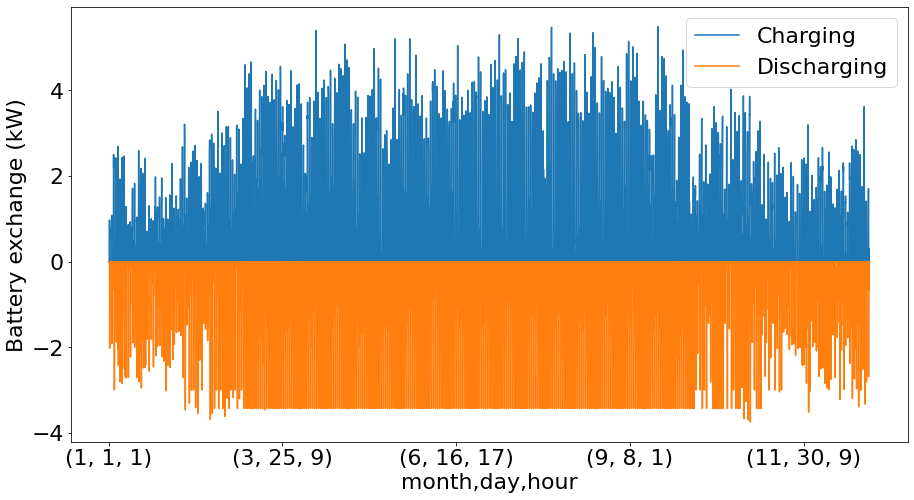

In [149]:
power_balance[['Charging', 'Discharging']].plot(ylabel = 'Battery exchange (kW)'); 

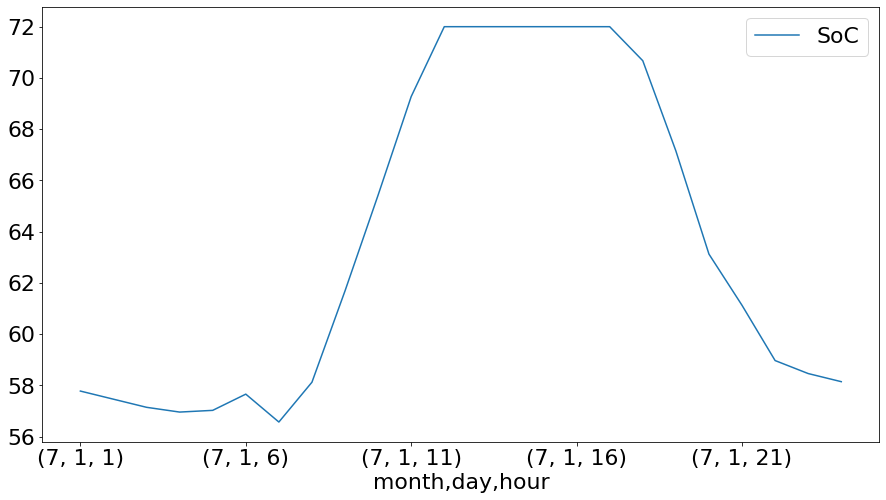

In [150]:
power_balance[['SoC']].iloc[power_balance.index.get_level_values('month') == 7].head(24).plot();

In [151]:
sum(power_balance['Charging'])

4896.156880190891

In [152]:
sum(power_balance['Discharging'])

-4161.733348162379

Check how many cycles were carried out

In [153]:
sum(power_balance['Charging'])/battery_size

68.00217889154015

In [154]:
power_balance['exchange grid new'] = power_balance['to Grid New'] - power_balance['from Grid New']

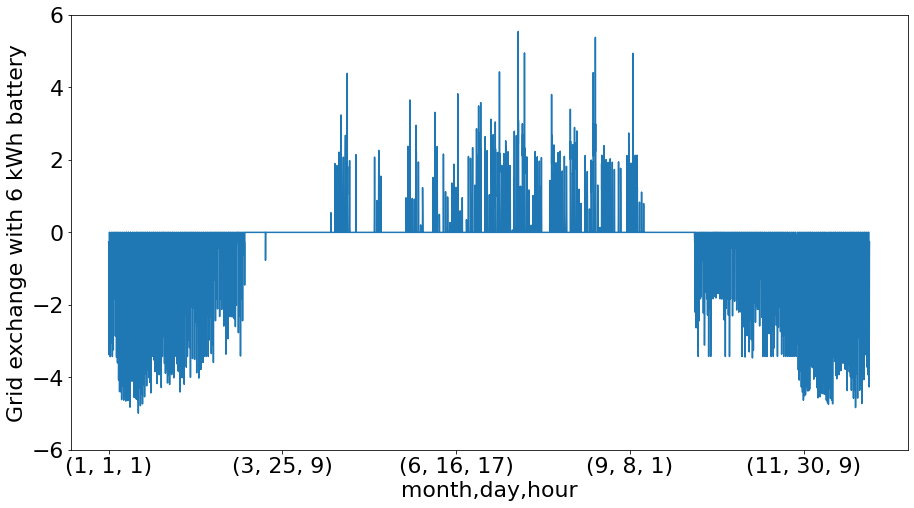

In [155]:
power_balance['exchange grid new'].plot(ylabel = 'Grid exchange with 6 kWh battery', ylim = ([-6, 6]));

Self-consumption share with BESS

In [156]:
sum(power_balance['consumption'] - power_balance['from Grid New'])/sum(power_balance['from PV'])

0.8361518971586189

Curtailment calculation with BESS

In [157]:
sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

0.07841912658521101

PV share with BESS

In [158]:
1-sum(power_balance['from Grid New'])/sum(power_balance['consumption'])

0.754317820459077

Losses in the battery system

In [159]:
(sum(power_balance['Charging']) + sum(power_balance['Discharging']))/sum(power_balance['from PV'])

0.08542897625614043

Reduced consumption from grid:
also mention PV reduction, check with curtailment!

In [160]:
grid_savings = sum(power_balance['Discharging'])
grid_savings

-4161.733348162379

## CO$_2$ calculations

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [162]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot

In [163]:
os.chdir('/home/MA')

In [164]:
PV_lifetime = 25 #years

In [165]:
power_balance = pd.read_pickle('Calculations/CH/power_balance_CH_no_AC.pkl')

Emissions of grid mix at consumer level are taken from https://www.bafu.admin.ch/bafu/de/home/themen/klima/klimawandel--fragen-und-antworten.html#:~:text=Die%20Kennzahlen%20f%C3%BCr%20die%20verschiedenen,)%20(relevant%20f%C3%BCr%20volkswirtschaftliche%20Betrachtungen)

In [166]:
grid_emissions_CH= 181.5 # g CO2/kWh

In [167]:
battery_lifetime = 15 # years

Battery production energy intensity from https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

In [168]:
elec_battery_prod = 95.5 # kwh_el/kWh_n

Assumption: Battery production in China
at 637 g CO2/kWh
https://www.mdpi.com/1996-1073/14/4/961/pdf

In [169]:
CO2_intensity_China = 637

In [170]:
electricity_PV_production = 1597 # kWh_el kWp-1

### CO2 savings of PV only

Yearly energy self consumed, therefore reduced consumption from grid

In [171]:
self_consumption_kWh = sum(power_balance['consumption'] - power_balance['from Grid'])

In [172]:
total_CO2_PV_prod = electricity_PV_production * PV_size * CO2_intensity_China

In [173]:
reduced_CO2_PV_g = grid_emissions_CH * self_consumption_kWh * PV_lifetime - total_CO2_PV_prod

In [174]:
reduced_CO2_PV_t = reduced_CO2_PV_g/1000000

In [175]:
reduced_CO2_PV_t

7.629339780986242

### CO2 savings of added batteries

In [176]:
battery_size = [0, 6, 12, 18, 24, 72]
results = pd.DataFrame()
results['battery_size'] = battery_size
results['curtailment'] = ''
results['yearly_savings_kWh'] = ''

In [177]:
for i in range(0, len(results['battery_size'])):
    powerbalance = BatteryDispatch(power_balance, results['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
    results['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
    results['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

In [178]:
results['total_savings_kWh'] = results['yearly_savings_kWh'] * PV_lifetime

The yearly CO2 savings by grid consumption reduction in tons amount to:

In [179]:
results['yearly_savings_CO2'] = results['yearly_savings_kWh'] * grid_emissions_CH / 1000000

For a PV lifetime of 25 years, this corresponds to a gross saving of 

In [180]:
results['total_CO2_grid_reduced'] = results['yearly_savings_CO2'] * PV_lifetime

Caclculate total battery energy intensity by accounting for dead capacity (20%) which is not used when cycling to improve performance, and for a replacement after 15 years (battery lifetime)

In [181]:
results['total_elec_battery_prod'] = 2 * (elec_battery_prod * results['battery_size']/0.8)

Net saving of battery deployment

In [182]:
results['total_CO2_battery_prod'] = results['total_elec_battery_prod'] * CO2_intensity_China / 1000000

In [183]:
results['net_CO2_savings'] = results['total_CO2_grid_reduced'] - results['total_CO2_battery_prod'] 

In [184]:
results['stored'] = results.iloc[0]['curtailment'] - results['curtailment']

In [185]:
results

,battery_size,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored
0,0,0.647946,-0,-0,-0,-0,0.0,0.000000,-0,0
1,6,0.389679,1887.25,47181.1,0.342535,8.56338,1432.5,0.912502,7.65088,0.258267
2,12,0.208791,3209.06,80226.4,0.582444,14.5611,2865.0,1.825005,12.7361,0.439154
3,18,0.100981,3996.86,99921.6,0.725431,18.1358,4297.5,2.737507,15.3983,0.546964
4,24,0.0925945,4058.15,101454,0.736554,18.4138,5730.0,3.650010,14.7638,0.555351
5,72,0.0784191,4161.73,104043,0.755355,18.8839,17190.0,10.950030,7.93384,0.569527


In [186]:
results.set_index("battery_size",drop=True,inplace=True)

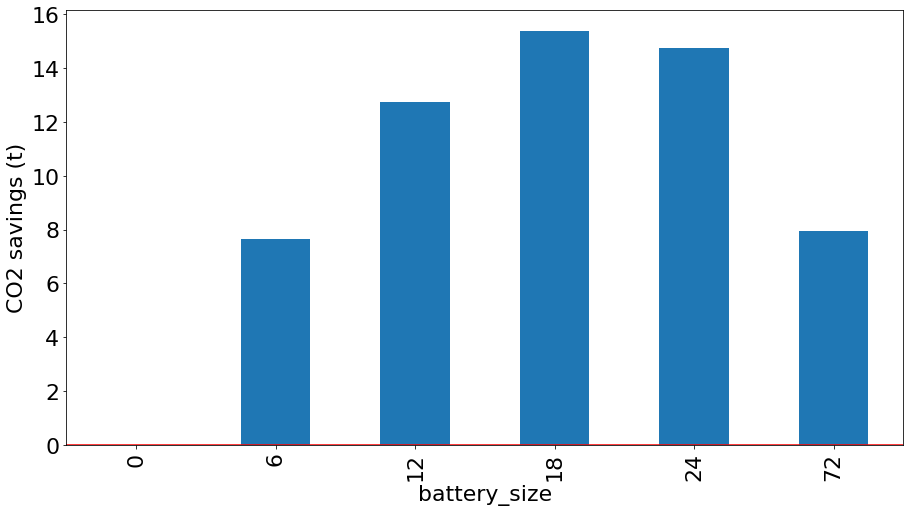

In [187]:
results['net_CO2_savings'].plot.bar(ylabel ='CO2 savings (t)');
plt.axhline(y=0, color='r', linestyle='-')

In [188]:
results['net_CO2_savings_with_PV'] = results['net_CO2_savings'] + reduced_CO2_PV_t

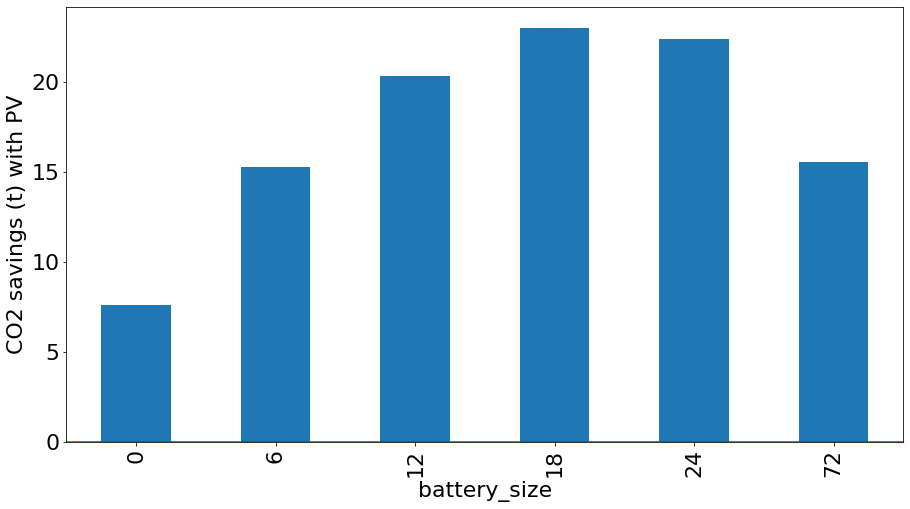

In [189]:
results['net_CO2_savings_with_PV'].plot.bar(ylabel ='CO2 savings (t) with PV');
plt.axhline(y=0, color='r', linestyle='-')

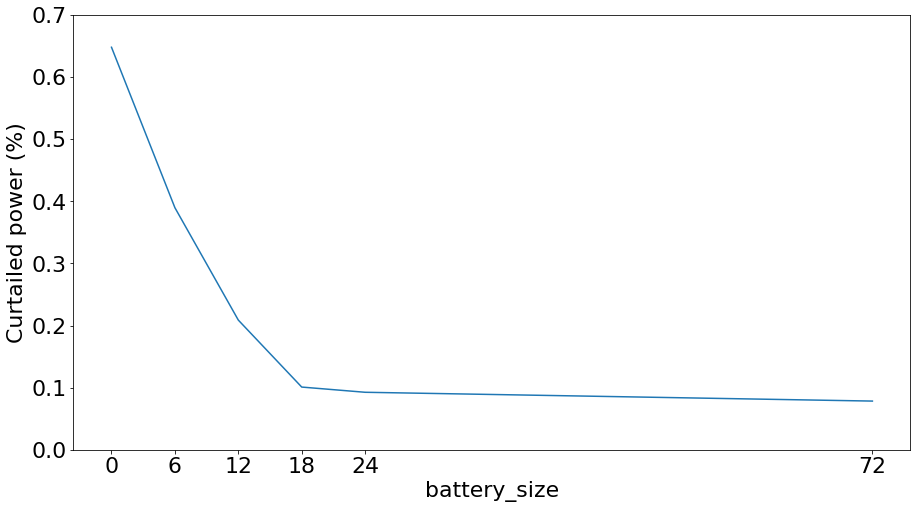

In [190]:
results['curtailment'].plot(xticks = battery_size, ylabel = 'Curtailed power (%)', ylim = ([0, 0.7]));

## EROI calculations

Electricity intensity used for PV production

In [191]:
PV_production_hourly = pd.read_pickle('Calculations/CH/PV_production_CH.pkl')

In [192]:
yearly_PV_production = sum(PV_production_hourly)

In [193]:
PV_size = 6 #kW_p

In [194]:
results['total_elec_PV_prod'] = electricity_PV_production * PV_size

In [195]:
results['ESOI'] = results['total_savings_kWh'].div(results['total_elec_battery_prod'].where(results['total_elec_battery_prod'] != 0, np.nan))

In [196]:
results['EROI_gen'] = yearly_PV_production*PV_lifetime/results['total_elec_PV_prod']

**Firstly, calculate the EROI for the case where electricity can be made usful through the distribution grid:**

In [197]:
results['EROI_grid_useful'] = results['EROI_gen']

**Now, let's consider the case where power is curtailed unless stored for later use**

In [198]:
results['EROI_grid_curtailed'] = (1 - results['stored'] + eta_discharge * results['stored'])/(1/results['EROI_gen']+results['stored']/results['ESOI'])*(1-results['curtailment'])

In [199]:
results['EROI_grid_curtailed'] = results['EROI_grid_curtailed'].fillna(results['EROI_gen']*(1-results['curtailment']))

In [200]:
results['ESOI'] = results['ESOI'].fillna(0)

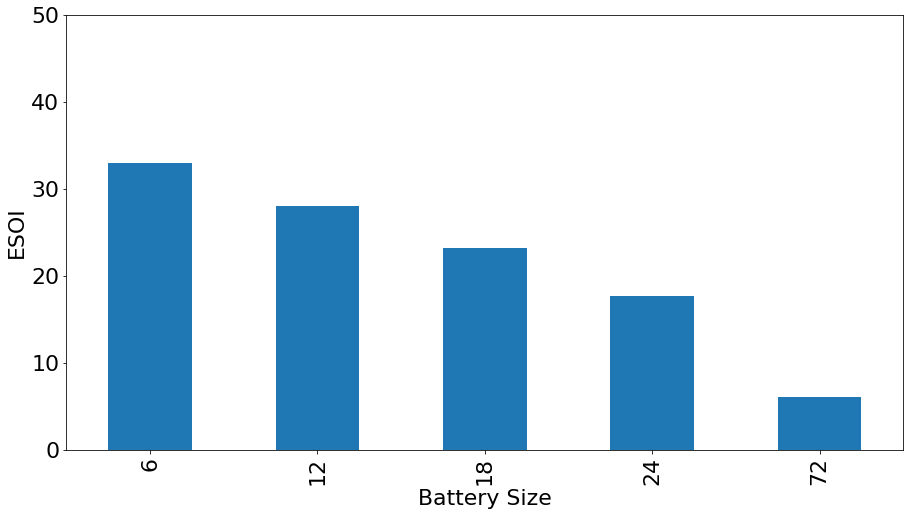

In [201]:
results.ESOI[results['ESOI']!=0].plot.bar(xlabel = 'Battery Size', ylabel = 'ESOI', ylim = ([0, 50]));

In [202]:
results

,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored,net_CO2_savings_with_PV,total_elec_PV_prod,ESOI,EROI_gen,EROI_grid_useful,EROI_grid_curtailed
battery_size,,,,,,,,,,,,,,,
0,0.647946,-0,-0,-0,-0,0.0,0.000000,-0,0,7.62934,9582,0.000000,22.429791,22.429791,7.896506
6,0.389679,1887.25,47181.1,0.342535,8.56338,1432.5,0.912502,7.65088,0.258267,15.2802,9582,32.936229,22.429791,22.429791,11.190794
12,0.208791,3209.06,80226.4,0.582444,14.5611,2865.0,1.825005,12.7361,0.439154,20.3654,9582,28.002246,22.429791,22.429791,12.263706
18,0.100981,3996.86,99921.6,0.725431,18.1358,4297.5,2.737507,15.3983,0.546964,23.0276,9582,23.251099,22.429791,22.429791,12.116954
24,0.0925945,4058.15,101454,0.736554,18.4138,5730.0,3.650010,14.7638,0.555351,22.3932,9582,17.705709,22.429791,22.429791,10.952268
72,0.0784191,4161.73,104043,0.755355,18.8839,17190.0,10.950030,7.93384,0.569527,15.5632,9582,6.052550,22.429791,22.429791,6.077647


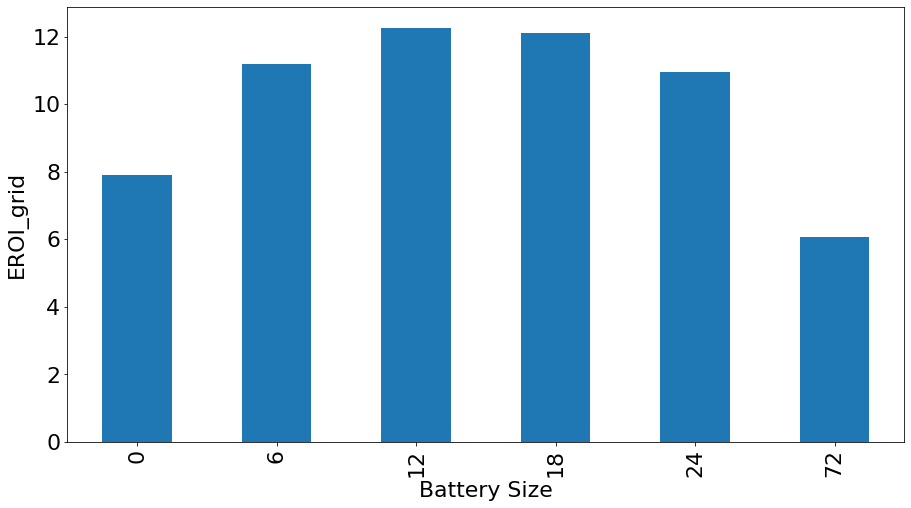

In [203]:
results['EROI_grid_curtailed'].plot.bar(xlabel = 'Battery Size', ylabel = 'EROI_grid');